In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tqdm import tqdm

df = pd.read_csv ('/data/Data/yntn/data_labeled.csv')

Text(0.5, 0, 'Label')

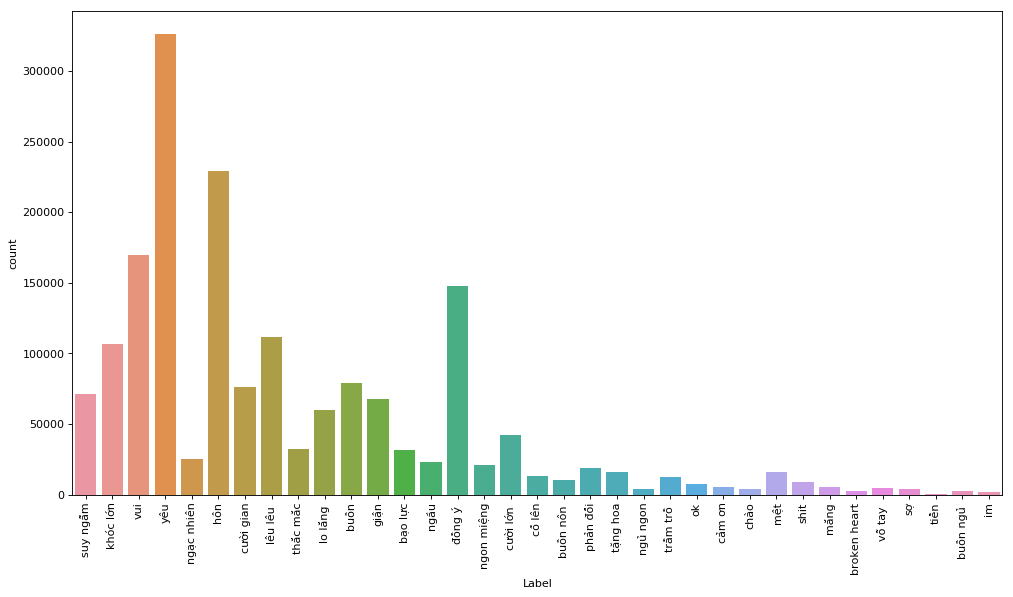

In [3]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [4]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.15)

In [6]:
max_words = 88860
max_len = 300
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [7]:
import pickle 
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

len(word_dict)

88856

In [84]:
w = np.random.normal(0, 1, (max_words, max_len))

In [85]:
# w = [[0]]*max_words
# w[0] = np.array([0]*max_len)

for i in range (1, len(tok.index_word)):
#     if (i <= len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]
#     else:
#             w[i] = np.array([0]*max_len)
#     else:
#         w[i] = np.array([0]*max_len)

In [86]:
w = np.array(w)
w

array([[-5.73346055e-01, -1.06964506e-01,  6.08319389e-01, ...,
         1.85636501e+00, -1.71740334e-01, -1.68148985e+00],
       [ 8.71500000e-03,  3.02390009e-02,  1.43621996e-01, ...,
        -2.25799996e-03,  3.41322988e-01,  1.82750002e-01],
       [-2.71988988e-01,  8.45220014e-02,  4.57614005e-01, ...,
         2.25976005e-01,  1.31023005e-01,  3.99334013e-01],
       ...,
       [ 1.15770174e+00,  2.38719908e-01, -1.24263589e-01, ...,
        -2.17078045e+00, -6.92756105e-01,  9.07606358e-01],
       [ 7.63247365e-01, -1.42383556e+00,  1.78195899e+00, ...,
        -8.36883929e-02, -2.24278256e-01,  3.47730347e-02],
       [ 2.60028495e+00,  4.34844972e-01,  7.58494056e-01, ...,
         6.21353752e-01,  6.34513317e-01,  1.63841607e+00]])

In [90]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [91]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 300, 300)          26658000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [92]:
model.compile(loss='binary_crossentropy',optimizer = RMSprop(),metrics=['accuracy'])

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1196736 samples, validate on 299184 samples
Epoch 1/10
 156288/1196736 [==>...........................] - ETA: 1:01:26 - loss: -308.8817 - acc: 0.0014

In [ ]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))